In [228]:
import numpy             as np
import matplotlib.pyplot as plt

from scipy.signal import lfilter

In [229]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

## Create a signal for demonstration.

In [258]:
sample_rate = 48000
nsamples    = 1000

freq = [1000, 3000, 10000, 15000, 20000]

t = np.arange(nsamples) / sample_rate

sum = np.zeros_like(t)
for i in range (len(freq)):
    sum = sum + np.sin(t*freq[i]*2*np.pi)

x = sum/len(freq)

## Create a FIR filter and apply it to x.

In [259]:
taps = np.array([1915, 5389, 8266, 9979, 8266, 5389, 1915])
taps = np.int16(taps)/2**16
# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

## Plot the FIR filter coefficients.

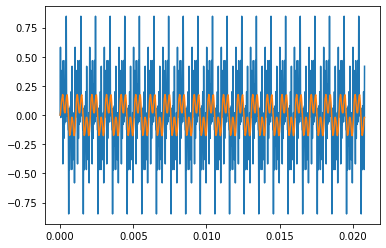

In [260]:
plt.plot(t,x)
plt.plot(t, filtered_x)


plt.show()

## Save the input and output to txt files

In [261]:
x_stereo     = np.stack((x         , x         ), axis=1)
x_fil_stereo = np.stack((filtered_x, filtered_x), axis=1)
np.savetxt("input_file.txt" , np.int32(x_stereo*2**23)    , fmt='%i')
np.savetxt("output_file.txt", np.int32(x_fil_stereo*2**23), fmt='%i')

## FFT plot

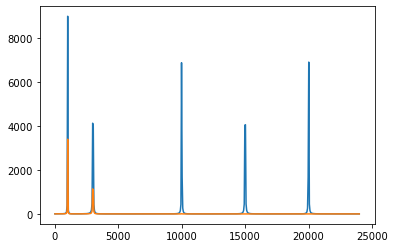

In [262]:
freq_dom = np.linspace(0,sample_rate/2, int(nsamples/2+1), endpoint=True)

fft_unf = np.fft.rfft(x)
fft_fil = np.fft.rfft(filtered_x)
plt.plot(freq_dom, np.abs(fft_unf)**2)
plt.plot(freq_dom, np.abs(fft_fil)**2)

plt.show()

## Apply white noise to the filter

In [263]:
x = band_limited_noise(20, 24000, 48000, 48000)
filtered_x = lfilter(taps, 1.0, x)

(-100.0, 10.0)

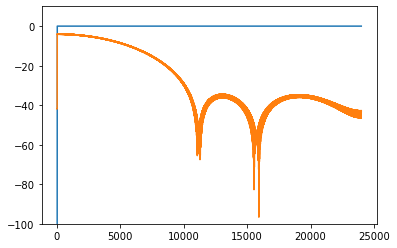

In [264]:
freq_dom = np.linspace(0,48000/2, int(48000/2+1), endpoint=True)

fft_unf = np.fft.rfft(x)
fft_fil = np.fft.rfft(filtered_x)

plt.plot(freq_dom, 10*np.log10(np.abs(fft_unf)**2))
plt.plot(freq_dom, 10*np.log10(np.abs(fft_fil)**2))

plt.ylim(-100,10)